In [1]:
import sqlite3
import pandas
import matplotlib.pyplot as plt
import os
os.system('clear')

0

In [2]:
DB_FILE = "database.sqlite"
try:
    conn = sqlite3.connect(DB_FILE)

    # Use pandas as a quick way to load SQLite data into dataframes
    users = pandas.read_sql_query("SELECT * FROM users", conn)
    posts = pandas.read_sql_query("SELECT * FROM posts", conn)
    comments = pandas.read_sql_query("SELECT * FROM comments", conn)
    reactions = pandas.read_sql_query("SELECT * FROM reactions", conn)

    # Let's make sure our data is okay by quickly inspecting all the tables
    print(users)
    print(posts)
    print(comments)
    print(reactions)

except Exception as e:
    print(f"Error '{e}'")
finally:
    if conn:
        conn.close()
        print("SQLite Database connection closed.")

      id         username              location   birthdate  \
0      1     artistic_amy           Boston, USA  1997-06-30   
1      2    traveller_tom       Berlin, Germany  1990-10-12   
2      3      coder_chris  Melbourne, Australia  1983-01-25   
3      4       baker_beth         Paris, France  1994-12-05   
4      5      runner_ryan          Tokyo, Japan  1986-04-18   
..   ...              ...                   ...         ...   
205  529    music_maestro        Nashville, USA  1991-02-14   
206  530      coding_whiz           Austin, USA  1995-09-25   
207  531        sky_diver            Dubai, UAE  1990-06-11   
208  532  crafty_creative      Lisbon, Portugal  1996-07-30   
209  533      eco_warrior     Stockholm, Sweden  1994-11-05   

              created_at                                            profile  \
0    2022-07-01 12:17:48  Artistic soul from Boston ? | Born in '97 | Ba...   
1    2022-05-17 17:32:48  Berlin native, born on 10/12/90. ? Cinephile w...   
2    2

Monthly Activity Growth
      month  activity_count  cumulative_activity
0   2021-04               6                    6
1   2021-05              10                   16
2   2021-06               8                   24
3   2021-07               8                   32
4   2021-08               9                   41
5   2021-09               7                   48
6   2021-10               8                   56
7   2021-11               7                   63
8   2021-12               7                   70
9   2022-01               6                   76
10  2022-02               5                   81
11  2022-03               8                   89
12  2022-04               6                   95
13  2022-05               7                  102
14  2022-06               4                  106
15  2022-07               6                  112
16  2022-08               6                  118
17  2022-09               3                  121
18  2022-10               7                  

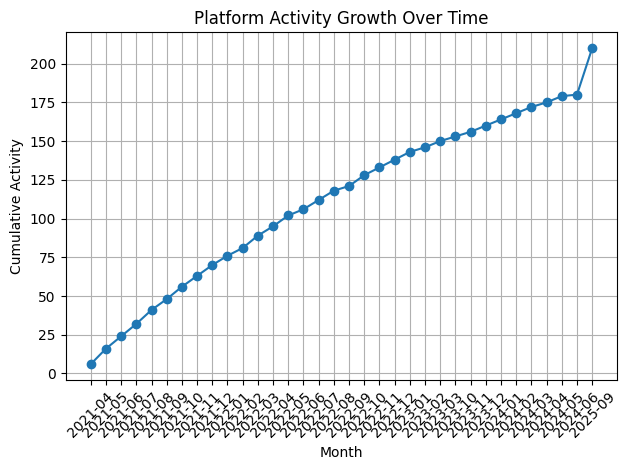

In [36]:
#Task 1
all_activity = pandas.concat([
    users[['created_at']],
    posts[['created_at']],
    comments[['created_at']]
])

#Extract YYYY-MM
all_activity['month'] = all_activity['created_at'].str[:7]

#Activity per month
monthly_activity = all_activity.groupby('month').size().reset_index(name='activity_count')
monthly_activity = monthly_activity.sort_values('month')

#Cumulative activity
monthly_activity['cumulative_activity'] = monthly_activity['activity_count'].cumsum()

print("Monthly Activity Growth")
print(monthly_activity)

#Growth rate calculation
n_months = len(monthly_activity)
total_activity = monthly_activity['cumulative_activity'].iloc[-1]
avg_monthly_growth = total_activity / n_months

print(f"\nCurrent total activity: {total_activity}")
print(f"Average monthly growth: {avg_monthly_growth:.2f}")

#3 yrs project
months_ahead = 36
projected_activity = total_activity + (avg_monthly_growth * months_ahead)

print(f"\nProjected activity in 3 years: {projected_activity:.0f}")

#Servers needed
current_servers = 16
activity_per_server = total_activity / current_servers
servers_needed = projected_activity / activity_per_server
servers_with_redundancy = servers_needed * 1.20

additional_servers = servers_with_redundancy - current_servers

print(f"\nCurrent servers: {current_servers}")
print(f"Activity per server: {activity_per_server:.2f}")
print(f"Servers needed in 3 years: {servers_needed:.2f}")
print(f"Servers with 20% redundancy: {servers_with_redundancy:.2f}")
print(f"Additional servers to rent: {additional_servers:.2f} ~ {int(additional_servers) + 1}")

#Plot
plt.plot(monthly_activity['month'], monthly_activity['cumulative_activity'], marker='o')
plt.title("Platform Activity Growth Over Time")
plt.xlabel("Month")
plt.ylabel("Cumulative Activity")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
#Task 2
#Count reaction and comments per post
comment_counts = comments.groupby('post_id').size().reset_index(name='comment_count')
reaction_counts = reactions.groupby('post_id').size().reset_index(name='reaction_count')

#Join posts with comment counts
posts_with_engagement = posts.merge(
    comment_counts,
    left_on='id', right_on='post_id',
    how='left'
)

#Join with reaction counts
posts_with_engagement = posts_with_engagement.merge(
    reaction_counts,
    left_on='id', right_on='post_id',
    how='left',
    suffixes=('', '_reactions')
)

#Calculate viral score
posts_with_engagement['virality_score'] = posts_with_engagement['comment_count'] + posts_with_engagement['reaction_count']

#Sorting
posts_with_engagement = posts_with_engagement.sort_values('virality_score', ascending=False)

#Top 3
top_viral_posts = posts_with_engagement.head(3)[['id', 'user_id', 'content', 'comment_count', 'reaction_count', 'virality_score']]

print("Top 3 Most Viral Posts")
print(top_viral_posts)

Top 3 Most Viral Posts
        id  user_id                                            content  \
633   2351       94  Just finished a DIY project turning old pallet...   
1095  2813      135  Recently, I've been reflecting on the importan...   
477   2195       78  Cooked up a vegan feast last night and managed...   

      comment_count  reaction_count  virality_score  
633            62.0           139.0           201.0  
1095           82.0           103.0           185.0  
477            45.0           133.0           178.0  


In [39]:
#Task 3
#Convert to datetime
posts['created_at'] = pandas.to_datetime(posts['created_at'])
comments['created_at'] = pandas.to_datetime(comments['created_at'])

#Join posts with comments
posts_with_comments = posts.merge(
    comments[['post_id', 'created_at']],
    left_on='id', right_on='post_id',
    how='inner',
    suffixes=('_post', '_comment')
)

#Time difference
posts_with_comments['time_diff'] = (posts_with_comments['created_at_comment'] - posts_with_comments['created_at_post']).dt.total_seconds() / 3600

#First engagement per post
first_engagement = posts_with_comments.groupby('id')['time_diff'].min().reset_index(name='first_engagement_hours')

#Llast engagement per post
last_engagement = posts_with_comments.groupby('id')['time_diff'].max().reset_index(name='last_engagement_hours')

#Avg
avg_first = first_engagement['first_engagement_hours'].mean()
avg_last = last_engagement['last_engagement_hours'].mean()

print(f"Average time to first engagement: {avg_first:.2f} hours")
print(f"Average time to last engagement: {avg_last:.2f} hours")


Average time to first engagement: 45.18 hours
Average time to last engagement: 138.95 hours


In [38]:
#Task 4
#Find set of user pairs who where user A commented on posts of user B
comments_with_posters = comments.merge(
    posts[['id', 'user_id']],
    left_on='post_id', right_on='id',
    suffixes=('_commenter', '_poster')
)

#Find set of user pairs who where user A racted on posts of user B
reactions_with_posters = reactions.merge(
    posts[['id', 'user_id']],
    left_on='post_id', right_on='id',
    suffixes=('_reactor', '_poster')
)

#Combining
all_interactions = pandas.concat([
    comments_with_posters[['user_id_commenter', 'user_id_poster']].rename(columns={'user_id_commenter': 'user_a', 'user_id_poster': 'user_b'}),
    reactions_with_posters[['user_id_reactor', 'user_id_poster']].rename(columns={'user_id_reactor': 'user_a', 'user_id_poster': 'user_b'})
])

#No dups
all_interactions['pair'] = all_interactions.apply(
    lambda row: tuple(sorted([row['user_a'], row['user_b']])),
    axis=1
)

#Interaction
pair_counts = all_interactions.groupby('pair').size().reset_index(name='mutual_engagement')

#Top 3
top_connections = pair_counts.sort_values('mutual_engagement', ascending=False).head(3)

print("Top 3 User Pairs with Most Mutual Engagement")
print(top_connections)

Top 3 User Pairs with Most Mutual Engagement
          pair  mutual_engagement
2373  (38, 88)                 16
632    (9, 51)                 13
961   (13, 54)                 13


In [ ]:
import json
from google.colab import _message

ipynb = _message.blocking_request('get_ipynb')['ipynb']
with open("/content/HomeworkTask2.ipynb", "w") as f:
    f.write(json.dumps(ipynb))

print("Notebook saved as /content/HomeworkTask2.ipynb")
